<a href="https://colab.research.google.com/github/Lee-nahyung/AI-image/blob/main/Resnet18%20(%ED%95%99%EC%8A%B5%EB%A5%A0%200.0015).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim
import torch
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기

Saving LeopardCatAndCat.zip to LeopardCatAndCat (1).zip


In [3]:
!unzip LeopardCatAndCat.zip -d LeopardCatAndCat/    #LeopardCatAndCat 폴더 압축풀기

Archive:  LeopardCatAndCat.zip
   creating: LeopardCatAndCat/LeopardCatAndCat/test/
   creating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8100.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8101.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8102.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8103.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8104.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8105.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8106.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8107.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8108.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8109.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8110.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8111.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu 우선으로 돌릴 것

In [5]:
#train 셋이다. 
data_path = '/content/LeopardCatAndCat/LeopardCatAndCat/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

#--train 셋이다

220


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
#test셋이다

test_path = '/content/LeopardCatAndCat/LeopardCatAndCat/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))
#--test셋이다

40


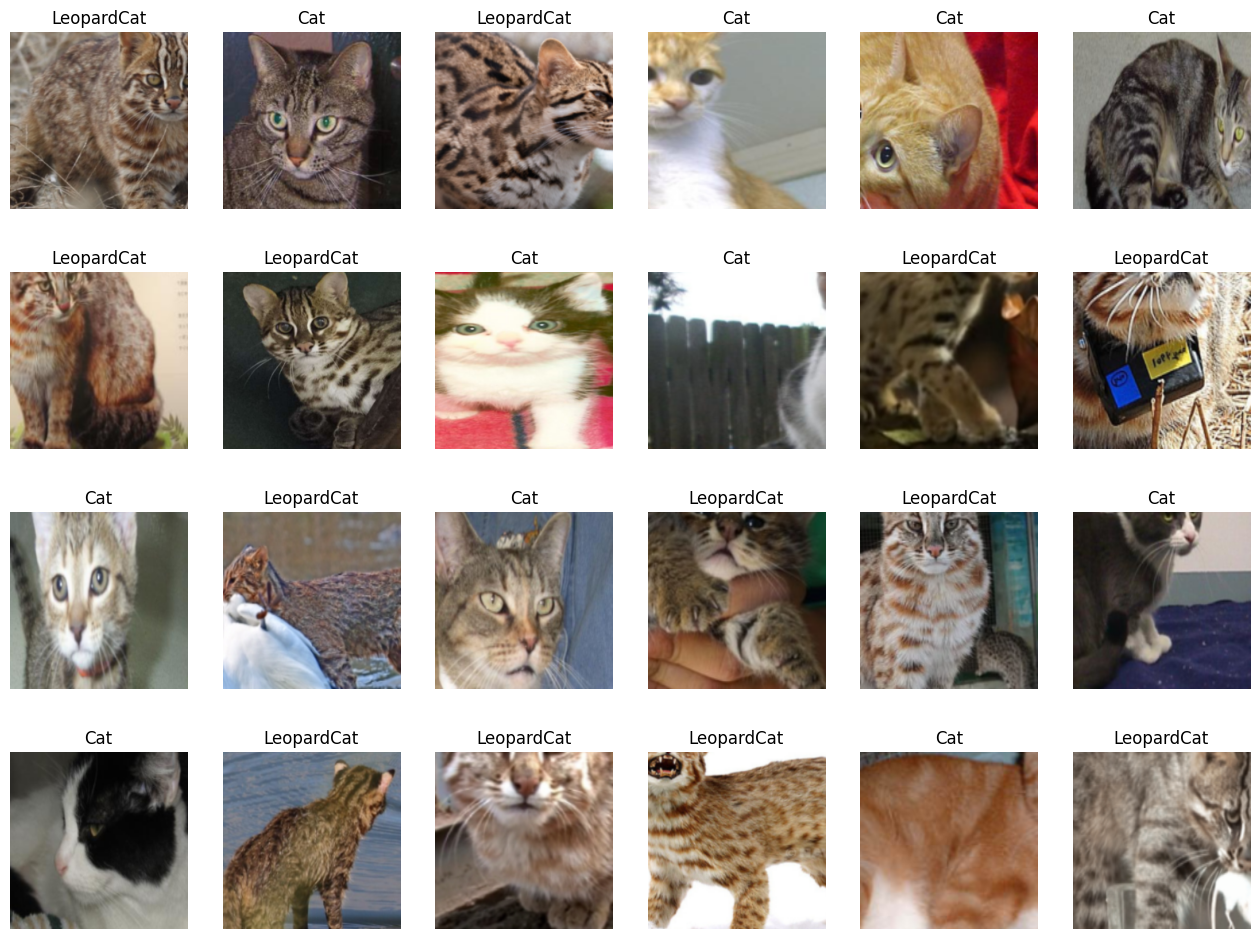

In [7]:
#dataset 보여주기
samples, labels = next(iter(train_loader))
classes = {0:'Cat', 1:'LeopardCat'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
#--dataset보여주기

In [18]:
#VGG19

dataset = torchvision.datasets.ImageFolder(root='/content/LeopardCatAndCat/LeopardCatAndCat/train/', transform=transform)
print("No of Classes:", len(dataset))

total_samples = len(dataset)
train_size = int(0.8 * total_samples)  # 전체 데이터셋의 70%를 학습에 사용
val_size = total_samples - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=True)

vgg = torchvision.models.vgg19(pretrained=True)
vgg.classifier[6].out_features = 5
for param in vgg.features.parameters():
    param.requires_grad = False

vgg = vgg.to(device)

No of Classes: 220


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
#Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)

In [20]:
#Training Model 
total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []


for epoch in range(n):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    vgg.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = vgg(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(val_loader):
    vgg.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = vgg(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(val_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  
  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)

Epoch 1 =>  loss : 1.73;   Accuracy : 47.16%;   Val_loss : 0.25;   Val_Accuracy : 81.82%
Epoch 2 =>  loss : 1.88;   Accuracy : 78.98%;   Val_loss : 0.79;   Val_Accuracy : 84.09%
Epoch 3 =>  loss : 4.57;   Accuracy : 90.91%;   Val_loss : 0.10;   Val_Accuracy : 84.09%
Epoch 4 =>  loss : 0.37;   Accuracy : 90.34%;   Val_loss : 2.29;   Val_Accuracy : 86.36%
Epoch 5 =>  loss : 0.00;   Accuracy : 94.32%;   Val_loss : 1.15;   Val_Accuracy : 86.36%
Epoch 6 =>  loss : 0.00;   Accuracy : 97.16%;   Val_loss : 1.01;   Val_Accuracy : 84.09%
Epoch 7 =>  loss : 0.00;   Accuracy : 98.30%;   Val_loss : 1.27;   Val_Accuracy : 84.09%
Epoch 8 =>  loss : 0.00;   Accuracy : 98.30%;   Val_loss : 1.56;   Val_Accuracy : 95.45%
Epoch 9 =>  loss : 0.00;   Accuracy : 99.43%;   Val_loss : 0.00;   Val_Accuracy : 95.45%
Epoch 10 =>  loss : 0.00;   Accuracy : 100.00%;   Val_loss : 0.00;   Val_Accuracy : 95.45%


KeyboardInterrupt: ignored

RuntimeError: ignored

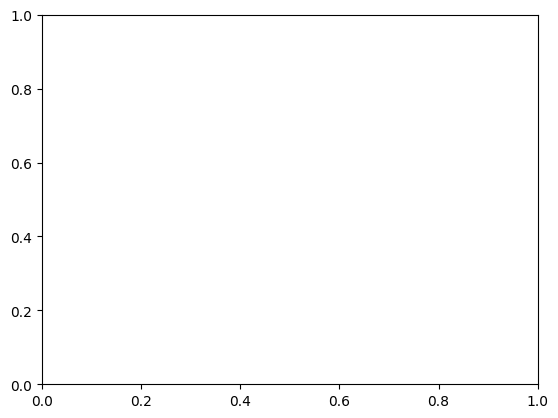

In [21]:
#show

plt.plot(range(n),Loss)
plt.plot(range(n),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

In [17]:
#Model Evaluation

vgg.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        y_pred = []
        Images = images.to(device)
        Labels = labels.to(device)
        outputs = vgg(Images)
        prediction_array = outputs.data
        
        _, predicted = torch.max(prediction_array, 1)
        y_pred += predicted
        total += Labels.size(0)
        correct += (predicted == Labels).sum().item()

    acc = 100 * correct / total
    Accuracies.append(acc)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

NameError: ignored

In [11]:
resnet = torchvision.models.resnet18(pretrained=True)

ftr = resnet.fc.in_features
resnet.fc = nn.Linear(ftr, 5)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0015) #옵티마이저로 아담 사용

total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []
n=10

dataset = train_dataset

total_samples = len(dataset)
train_size = int(0.8 * total_samples)  # 전체 데이터셋의 80%를 학습에 사용
val_size = total_samples - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=True)

for epoch in range(n):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    resnet.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(val_loader):
    resnet.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(val_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))

  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)

Epoch 1 =>  loss : 1.20;   Accuracy : 69.89%;   Val_loss : 66.67;   Val_Accuracy : 43.18%
Epoch 2 =>  loss : 0.37;   Accuracy : 77.27%;   Val_loss : 192.56;   Val_Accuracy : 43.18%
Epoch 3 =>  loss : 0.51;   Accuracy : 84.09%;   Val_loss : 2.44;   Val_Accuracy : 79.55%
Epoch 4 =>  loss : 0.44;   Accuracy : 85.23%;   Val_loss : 2.07;   Val_Accuracy : 59.09%
Epoch 5 =>  loss : 0.41;   Accuracy : 87.50%;   Val_loss : 0.64;   Val_Accuracy : 81.82%
Epoch 6 =>  loss : 0.16;   Accuracy : 89.77%;   Val_loss : 0.52;   Val_Accuracy : 79.55%
Epoch 7 =>  loss : 0.50;   Accuracy : 90.91%;   Val_loss : 1.37;   Val_Accuracy : 88.64%
Epoch 8 =>  loss : 0.08;   Accuracy : 88.64%;   Val_loss : 0.12;   Val_Accuracy : 93.18%
Epoch 9 =>  loss : 0.56;   Accuracy : 89.20%;   Val_loss : 0.22;   Val_Accuracy : 90.91%
Epoch 10 =>  loss : 0.04;   Accuracy : 93.18%;   Val_loss : 0.15;   Val_Accuracy : 95.45%
